In [1]:
from temp import ForestFireTemperatureSimulator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Example of using the advanced simulator with a forest fire
latitude = 30  # Specify the latitude of the point on Earth
target_average_temperature = 25  # Specify the target average temperature
min_temperature = 20  # Specify the minimum temperature
max_temperature = 60  # Specify the maximum temperature
oscillation_factor = 5  # Specify the oscillation factor
outlier_probability = 0  # Specify the probability of having an outlier
outlier_magnitude = 0  # Specify the magnitude of the outliers
fire_start_day = 10  # Specify the day when the forest fire starts (during summer)
fire_duration_days = 3  # Specify the duration of the forest fire
fire_magnitude = 50  # Specify the magnitude of the temperature spike during the fire
fire_smoothness = 3  # Specify the smoothness of the fire spike

forest_fire_simulator = ForestFireTemperatureSimulator(
    latitude, target_average_temperature, min_temperature, max_temperature,
    oscillation_factor, outlier_probability, outlier_magnitude,
    fire_start_day, fire_duration_days, fire_magnitude, fire_smoothness
)

# Simulate temperature for 265 days
num_days_to_simulate = 366

In [3]:
output = forest_fire_simulator.simulate_temperature_for_days(num_days_to_simulate)

In [4]:
output.keys()

dict_keys(['temps_vs_hours_of_doy', 'temperature_time_series', 'mean_temps_of_days', 'outliers'])

In [5]:
np.shape(output['temps_vs_hours_of_doy'])

(266, 4)

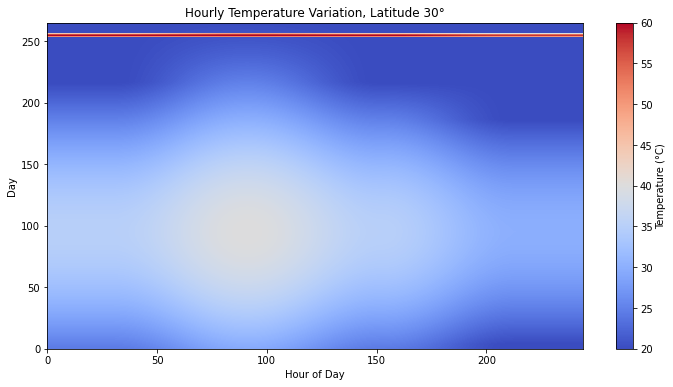

In [6]:
# Plotting
temps_vs_hours_of_doy = output['temps_vs_hours_of_doy']

fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.imshow(temps_vs_hours_of_doy, cmap='coolwarm', aspect='auto', extent=[0, 244, 0, num_days_to_simulate])
ax.set_title(f'Hourly Temperature Variation, Latitude {latitude}°')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Day')
cbar = fig.colorbar(cax, label='Temperature (°C)')
plt.show()


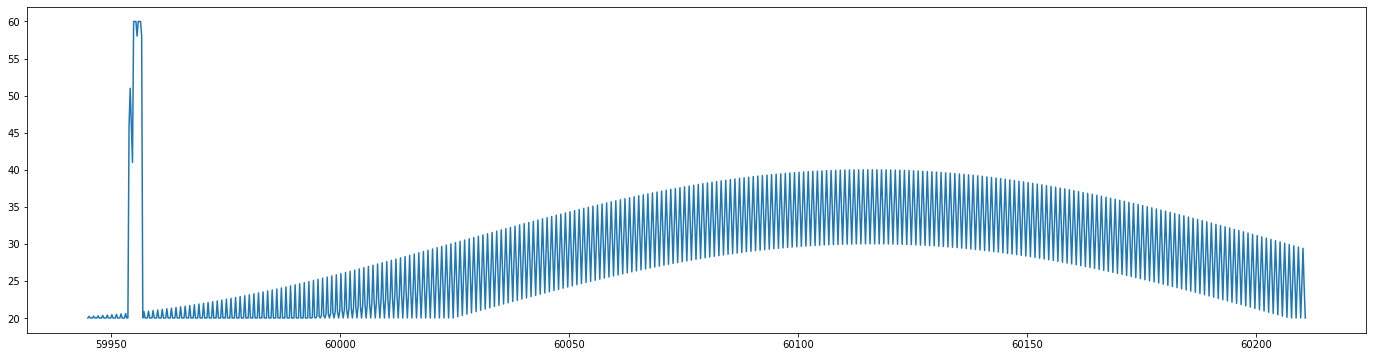

In [10]:
# Plotting
temps,mjds = output['temperature_time_series'].items()
outliers = output['outliers']
nmjds = np.array(mjds[1])[outliers]
ntmps = np.array(temps[1])[outliers]
# plt.plot(mjds[1],temps[1])
fig, ax = plt.subplots(figsize=(24, 6))
cax = ax.plot(mjds[1],temps[1])
ax.scatter(nmjds,ntmps,color='r')
# ax.set_title(f'Hourly Temperature Variation, Latitude {latitude}°')
# ax.set_xlabel('Hour of Day')
# ax.set_ylabel('Day')
# cbar = fig.colorbar(cax, label='Temperature (°C)')
plt.show()

In [11]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from scipy import signal

class GMLSQR():
    def __init__(self) -> None:
        pass
    
    def polynomial(self, x, *coefficients):
        """
        Polynomial function of order n based on the number of coefficients provided.
        """
        n = len(coefficients)
        return np.sum([coefficients[i] * np.power(x, n-i-1) for i in range(n)], axis=0)
    
    def detrend(self,x):
        return signal.detrend(x)

    def jacobian_matrix(self, x, *coefficients):
        """
        Calculate the Jacobian matrix for the polynomial function.
        """
        n = len(coefficients)
        jacobian_matrix = np.zeros((len(x), n))

        for i in range(n):
            derivative = np.power(x, n-i-1)
            jacobian_matrix[:, i] = derivative

        return jacobian_matrix

    def normalize_signal(self, signal):
        """
        Normalize the signal to the range [0, 1].
        """
        min_val = np.min(signal)
        max_val = np.max(signal)
        if max_val==min_val:
            normalized_signal=np.ones_like(signal)
        else:
            normalized_signal = (signal - min_val) / (max_val - min_val)
        return normalized_signal

    def denormalize_signal(self, normalized_signal, min_val, max_val):
        """
        Denormalize the signal using the original min and max values.
        """
        denormalized_signal = normalized_signal * (max_val - min_val) + min_val
        return denormalized_signal
    
    def estimatior(self,x,y,order:int=3 ):
        initial_guess = np.zeros(order)
        # Fit the data using curve_fit
        optimized_coefficients, pcov = curve_fit(self.polynomial, x, y, p0=initial_guess)
        y_pred = self.polynomial(x, *optimized_coefficients)
        residuals = y - y_pred
        mse = mean_squared_error(y, y_pred)
        stdev = np.std(residuals)
        # if stdev>=
        variance = np.var(residuals)
        return {'inp':{'x':x,'y':y,'order':order},
                'coefficients':optimized_coefficients,
                'estimation_predicitons':y_pred,
                'stats':{'mse':mse,'std':stdev,'var':variance},
                'residuals':residuals}
        
    def predict(self,x,coeffs):
        return self.polynomial(x,*coeffs)
        
    def get_outliers_z(self,y,threshold_stdev=2):    
        z_scores = (y - np.mean(y)) / np.std(y)
        # Adjust this value based on your requirements
        return np.abs(z_scores) > threshold_stdev

    def get_outliers_iq(self,y,threshold_iqr = 0.1):
        # Detect outliers based on interquartile method
        q1 = np.percentile(y, 25)
        q3 = np.percentile(y, 75)
        iqr = q3 - q1
        return (y < q1 - threshold_iqr * iqr) | (y > q3 + threshold_iqr * iqr)

In [ ]:
window_size = 4
import time
from IPython.display import clear_output

min_mjd = np.min(mjds[1])
mjds_lagged = np.subtract(mjds[1],min_mjd)
lsqr = GMLSQR()

for i,_ in enumerate(mjds_lagged):
    fig1, (ax1,ax2) = plt.subplots(2,figsize=(24, 12))
    # first window
    if i<21:
        x = mjds_lagged[:i+window_size+1]
        y = temps[1][:i+window_size+1]
    else:
        x = mjds_lagged[i-20:i+window_size+1]
        y = temps[1][i-20:i+window_size+1]
    y_normal = lsqr.normalize_signal(y)
    
    if i<5:
        order=2
    if i<20:
        order = i-5
    else:
        order = i+window_size
    # estimate and predict from estimation
    estimation = lsqr.estimatior(x,y_normal,order=5)
    optimized_coefficients = estimation['coefficients']
    y_pred = estimation['estimation_predicitons']
    
    # predict future
    n_next_epochs=1
    next_epoch = mjds_lagged[i+window_size:i+window_size+n_next_epochs+1]
    nexs_preds = lsqr.predict( next_epoch,optimized_coefficients)
    outliers = lsqr.get_outliers_z(y_normal,threshold_stdev=1.5)
    
    outlier_x = x[outliers]
    outlier_y = y_normal[outliers]    
    ax2.scatter(outlier_x,outlier_y,color='r',marker='*')
    
    idxs = np.where(outliers)[0]
    new_epochs =[]
    new_signal = []
    for j,epoch in enumerate(x):
        if j in idxs:continue
        new_epochs.append(epoch)
        new_signal.append(y_normal[j]) 
    estimation = lsqr.estimatior(new_epochs,new_signal,order=2)
    
    new_y_pred = lsqr.polynomial(new_epochs, *optimized_coefficients)
    # new_next_preds = lsqr.polynomial(next_epochs,*optimized_coefficients)
    new_residuals = new_signal - new_y_pred
    ax2.plot(new_epochs,new_residuals)
    new_mse = mean_squared_error(y_normal, y_pred)
    # new_stdev = np.std(residuals)
    
    # new_variance = np.var(residuals)
    ax2.plot(new_epochs,new_signal,color='m')
    ax2.plot(new_epochs,new_y_pred,color='c')
    # ax3.plot(next_epochs,new_next_preds,color='orange')

    ax1.plot(x,y_normal,color='k')
    ax1.plot(x,y_pred,color='y')
    ax1.scatter(next_epoch,nexs_preds,color='r')
    
    # ax1.plot(next_epochs,next_preds,color='orange',marker='*')
    # ax1.set_title(f'mse: {mse}')
    # ax.set_title(str(out))
    
    # ax2.plot(x,residuals)
    # ax2.set_title(f'std: {stdev} | var: {variance}')
    plt.show(block=False)
    clear_output(wait=True)
    # print("Optimized Coefficients:", optimized_coefficients)
    # print("Residuals:", residuals)
    # time.sleep(0.5)